In [1]:
import os
import pickle
import arviz as az
import networkx as nx
import matplotlib.pyplot as plt
import pymc as pm
import pytensor.tensor as pt

from data_graph_utils import *

from gp_on_graph_wrapper import GraphMaternKernel
from gp_on_graph_wrapper import GraphMaternKernel_numpy
from sklearn.cluster import KMeans

print(f"Running on PyMC v{pm.__version__}")
plt.rcParams['figure.figsize'] = [12, 4]

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/chris/anaconda3/envs/MARL_on_graph/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on PyMC v5.6.1


In [2]:
# LOAD INPUTS:

file_graph = "REPORT_adjusted.pkl"
file_graph = "./storage_graph/" + file_graph

In [3]:
#####################################################################################################
print("Loading Data...")
####

with open(file_graph, "rb") as file:
    graph = pickle.load(file)  
    graph.new_actions_ts = graph.actions_ts

Loading Data...


In [4]:
# Extracting the indicator time series for the selected nodes
var_d1 = "lonle_d1"
var_d2 = "lonle_d2"
indicator_d1 = graph.indicator_ts_dict[var_d1]
indicator_d2 = graph.indicator_ts_dict[var_d2]


used_ids = indicator_d1.index[(indicator_d1.isna().sum(axis=1) == 0) &
                                                (indicator_d2.isna().sum(axis=1) == 0)].values

if "lat" not in graph.bins_df.columns:
    graph.bins_df["lat"], graph.bins_df["lon"] = lv95_to_lat_long(graph.bins_df["mean_x"], graph.bins_df["mean_y"])

# subgraph laplacian:
G = nx.from_pandas_adjacency(graph.adj_matrix)
laplacian = nx.laplacian_matrix(G).todense()
eigenvalues, eigenvectors = np.linalg.eigh(laplacian)
eigenpairs = (eigenvalues, eigenvectors)

graph.adjust_actions_ts("lonle_d1", "lonle_d2", COEF_before=4, COEF_var=8)

indicator_d1 = graph.indicator_ts_dict["lonle_d1"]
indicator_d1_used = indicator_d1.iloc[used_ids, :]
indicator_d1_d_used = indicator_d1_used.diff(axis=1)
print("\tIndicator d1 shape: ", indicator_d1_used.shape)

indicator_d2 = graph.indicator_ts_dict["lonle_d2"]
indicator_d2_used = indicator_d2.iloc[used_ids, :]
indicator_d2_d_used = indicator_d2_used.diff(axis=1)
print("\tIndicator d2 shape: ", indicator_d2_used.shape)

# action ts:
action_ts = graph.actions_ts_adjusted
action_ts_used = action_ts.iloc[used_ids, :]
print("\tAction ts shape: ", action_ts_used.shape)


	Indicator d1 shape:  (100, 22)
	Indicator d2 shape:  (100, 22)
	Action ts shape:  (100, 22)


In [5]:
PROP_OF_TEST_NODES = 0
RND_SEED = 42
np.random.seed(RND_SEED)

n_test_nodes = int(PROP_OF_TEST_NODES * len(used_ids))
test_ids = np.random.choice(used_ids, n_test_nodes, replace=False)
train_ids = np.setdiff1d(used_ids, test_ids)

indicator_d1_train = indicator_d1_used.loc[train_ids, :]
indicator_d1_test = indicator_d1_used.loc[test_ids, :]
indicator_d2_train = indicator_d2_used.loc[train_ids, :]
indicator_d2_test = indicator_d2_used.loc[test_ids, :]
action_ts_train = action_ts_used.loc[train_ids, :]
action_ts_test = action_ts_used.loc[test_ids, :]

indicator_d1_d_train = indicator_d1_d_used.loc[train_ids, :]
indicator_d1_d_test = indicator_d1_d_used.loc[test_ids, :]
indicator_d2_d_train = indicator_d2_d_used.loc[train_ids, :]
indicator_d2_d_test = indicator_d2_d_used.loc[test_ids, :]

print("Train nodes:\t", len(train_ids))
print("Test nodes:\t", len(test_ids))

Train nodes:	 100
Test nodes:	 0


### Analyze trace

In [6]:
trace = az.from_netcdf("storage_inference/1223_1153___REPORT___1500s_2500t_4c___REPORT_adjusted__lonle_d1lonle_d2__.nc")

In [7]:
list(trace.posterior.data_vars)

['mu_init_d1',
 'mu_init_d2',
 'mu_d1',
 'mu_d2',
 'nu_d1',
 'lambda_act_d1',
 'lambda_act_d2',
 'lambda_ind',
 'kappa_g_init_d1',
 'sigma_g_init_d1',
 'kappa_g_init_d2',
 'sigma_g_init_d2',
 'k_d1',
 'k_d2',
 'kappa_g',
 'sigma_g',
 'ls_act',
 'ls_ind',
 'mu_1',
 'mu_2',
 'mu_3',
 'mu_4',
 'mu_5',
 'mu_6',
 'mu_7',
 'mu_8',
 'mu_9',
 'mu_10',
 'mu_11',
 'mu_12',
 'mu_13',
 'mu_14',
 'mu_15',
 'mu_16',
 'mu_17',
 'mu_18',
 'mu_19',
 'mu_20',
 'mu_21']

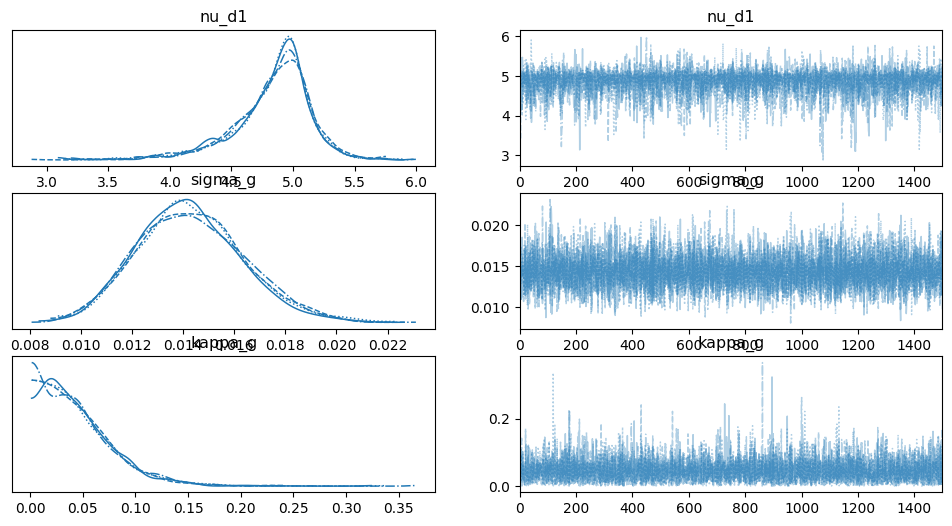

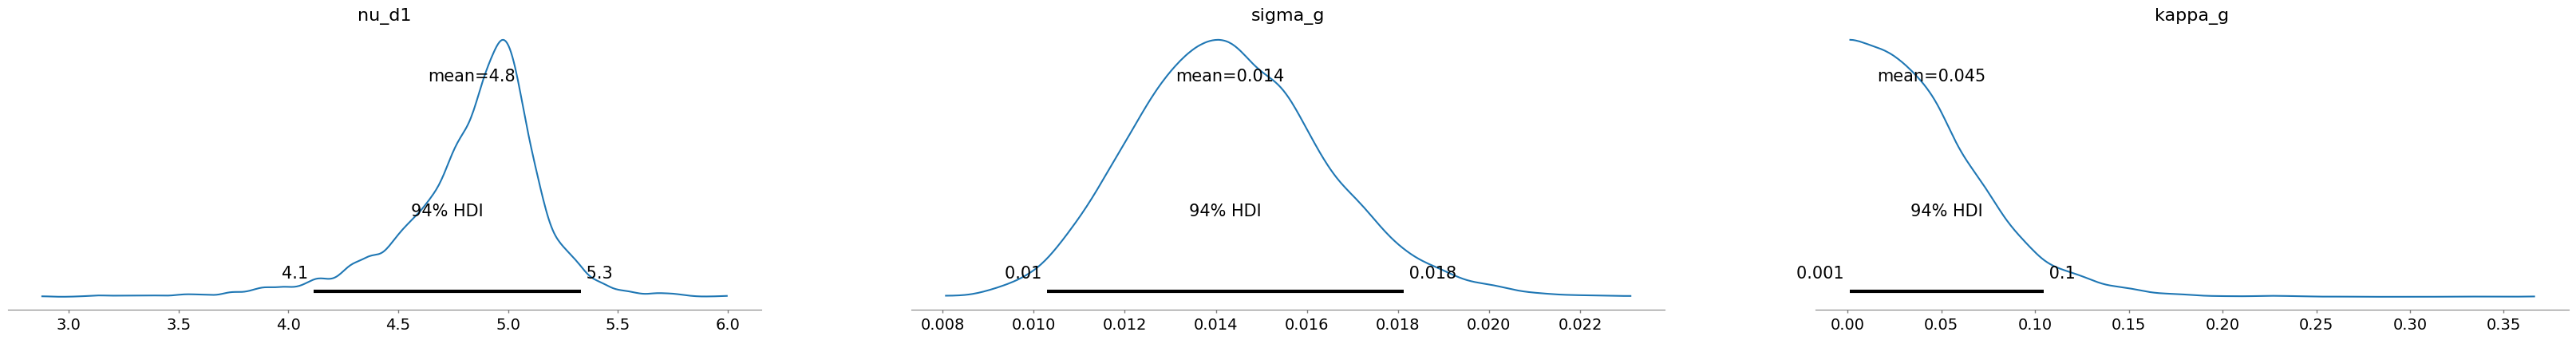

In [8]:
var_names = ["nu_d1", "sigma_g", "kappa_g"]

az.plot_trace(trace.posterior, var_names=var_names);
az.plot_posterior(trace.posterior, var_names=var_names);

In [9]:
# re-ordering the indices of the actions:

# rearange lambda_act_di: currently [n_chain x n_samples x 3] = [n_chain x n_samples x (re-tamping, tamping, renewal)]
# shift it to: [n_chain x n_samples x 3] = [n_chain x n_samples x (tamping, renewal, re-tamping)]
# we shift dimensions: new [:,:,0] = old [:,:,1], new [:,:,1] = old [:,:,2], new [:,:,2] = old [:,:,0]

trace.posterior = trace.posterior.assign_coords({"lambda_act_d1_dim_0": ["3", "1", "2"]})
trace.posterior = trace.posterior.assign_coords({"lambda_act_d2_dim_0": ["3", "1", "2"]})
trace.posterior = trace.posterior.assign_coords({"lambda_ind_dim_0": ["1"]})
trace.posterior = trace.posterior.assign_coords({"k_d1_dim_0":["3", "1", "2"]})
trace.posterior = trace.posterior.assign_coords({"k_d2_dim_0":["3", "1", "2"]})
trace.posterior = trace.posterior.assign_coords({"mu_d1_dim_0":["0", "3", "1", "2"]})
trace.posterior = trace.posterior.assign_coords({"mu_d2_dim_0":["0", "3", "1", "2"]})

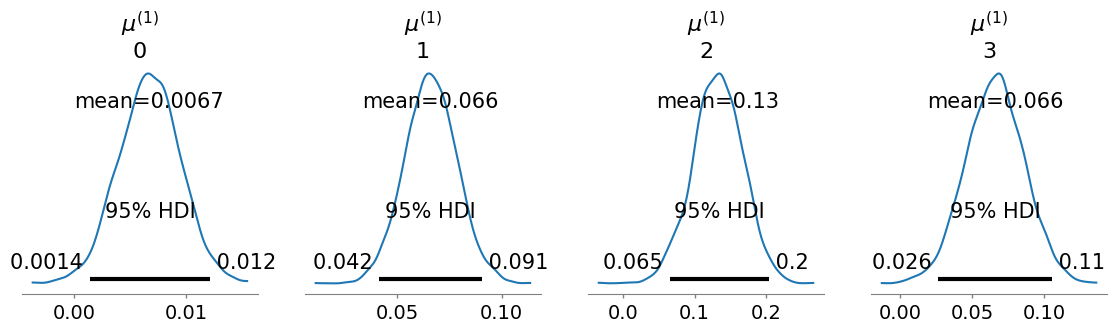

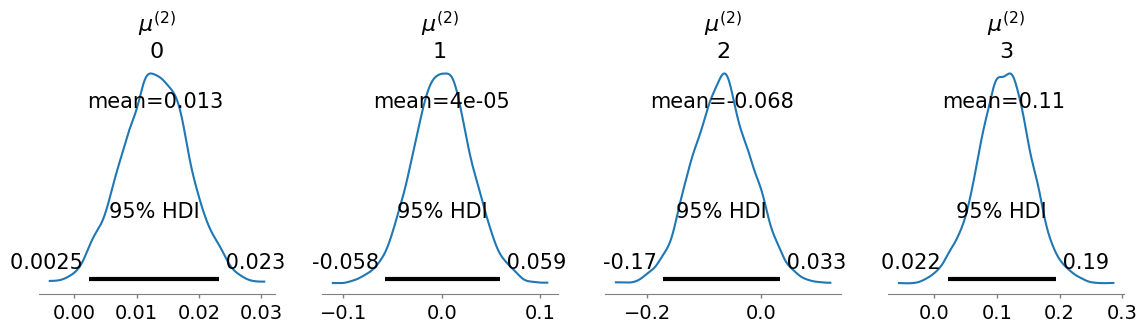

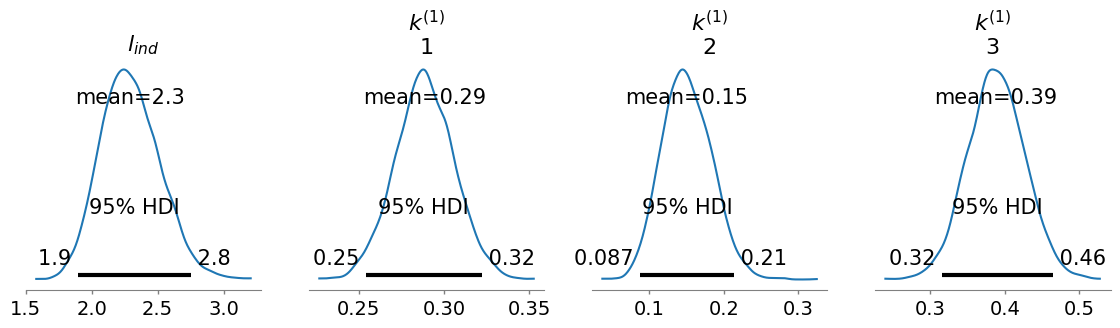

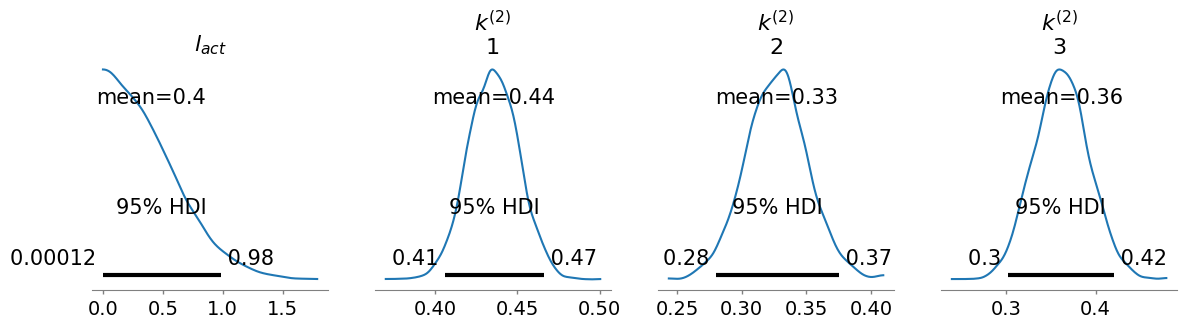

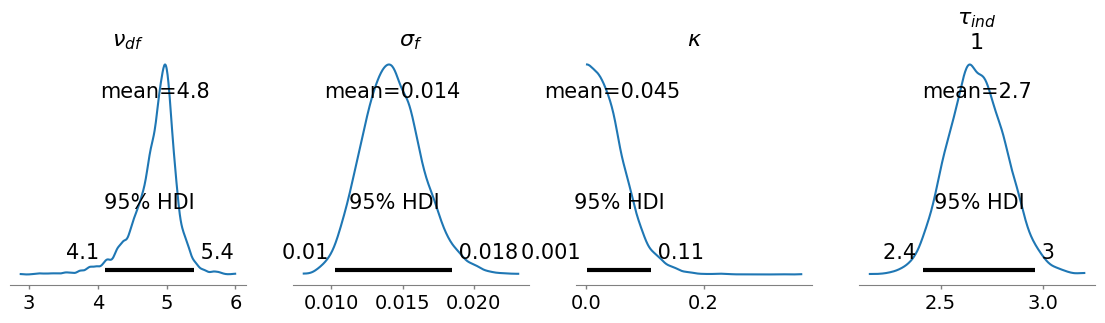

In [11]:
var_names_row1 = ["mu_d1"]
var_names_row2 = ["mu_d2"]
var_names_row3 = ["ls_ind", "k_d1"]
var_names_row4 = ["ls_act", "k_d2"]
var_names_row5 = ["nu_d1", "sigma_g", "kappa_g", "lambda_ind"]



import arviz.labels as azl
labeller = azl.MapLabeller(var_name_map={
    "mu_d1": r"$\mu^{(1)}$",
    "mu_d2": r"$\mu^{(2)}$",
    "ls_ind": r"$l_{ind}$",
    "k_d1": r"$k^{(1)}$",
    "ls_act": r"$l_{act}$",
    "k_d2": r"$k^{(2)}$",
    "nu_d1": r"$\nu_{df}$",
    "sigma_g": r"$\sigma_f$",
    "kappa_g": r"$\kappa$",
    "lambda_ind": r"$\tau_{ind}$",
})


az.plot_posterior(trace.posterior.sel(mu_d1_dim_0=["0","1","2","3"]), var_names=var_names_row1, 
                figsize=(14, 3), grid=(1, 4), labeller=labeller, 
                  point_estimate="mean", round_to=2, hdi_prob=0.95, kind="kde");

az.plot_posterior(trace.posterior.sel(mu_d2_dim_0=["0","1","2","3"]), var_names=var_names_row2, 
                  figsize=(14, 3), grid=(1,4), labeller=labeller, 
                  point_estimate="mean", round_to=2, hdi_prob=0.95, kind="kde");

az.plot_posterior(trace.posterior.sel(k_d1_dim_0=["1","2","3"]), var_names=var_names_row3, 
                  figsize=(14, 3), grid=(1, 4), labeller=labeller, 
                  point_estimate="mean", round_to=2, hdi_prob=0.95, kind="kde");

az.plot_posterior(trace.posterior.sel(k_d2_dim_0=["1","2","3"]), var_names=var_names_row4, 
                  figsize=(14, 3), grid=(1, 4), labeller=labeller, 
                  point_estimate="mean", round_to=2, hdi_prob=0.95, kind="kde");

az.plot_posterior(trace.posterior, var_names=var_names_row5,
                    figsize=(14, 3), grid=(1, 4), labeller=labeller, 
                    point_estimate="mean", round_to=2, hdi_prob=0.95, kind="kde");

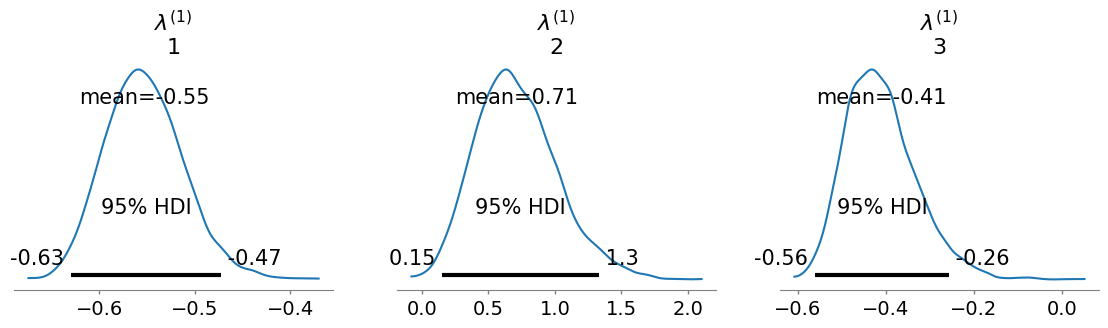

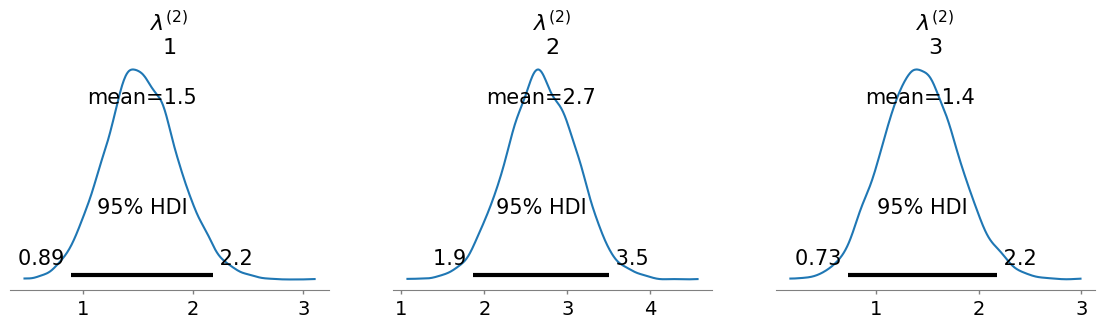

In [12]:
var_names_row1 = ["lambda_act_d1"]
var_names_row2 =["lambda_act_d2"]

import arviz.labels as azl
labeller = azl.MapLabeller(var_name_map={
    "mu_init_d1": r"$\mu_{init}^{(1)}$",
    "mu_init_d2": r"$\mu_{init}^{(2)}$",
    "kappa_g_init_d1": r"$\kappa_{init}^{(1)}$",
    "kappa_g_init_d2": r"$\kappa_{init}^{(2)}$",
    "sigma_g_init_d1": r"$\sigma_{f.init}^{(1)}$",
    "sigma_g_init_d2": r"$\sigma_{f.init}^{(2)}$",
    "lambda_act_d1": r"$\lambda^{(1)}$",
    "lambda_act_d2": r"$\lambda^{(2)}$",
})

# Plotting the mu_init variables in the first row (1 row, 2 columns)
az.plot_posterior(trace.posterior.sel(lambda_act_d1_dim_0=["1","2","3"]), var_names=var_names_row1, 
                figsize=(14, 3), grid=(1, 3), labeller=labeller, 
                  point_estimate="mean", round_to=2, hdi_prob=0.95, kind="kde");

# Plotting the kappa and sigma variables in the second row (2 rows, 2 columns)
az.plot_posterior(trace.posterior.sel(lambda_act_d2_dim_0=["1","2","3"]), var_names=var_names_row2, 
                  figsize=(14, 3), grid=(1,3), labeller=labeller, 
                  point_estimate="mean", round_to=2, hdi_prob=0.95, kind="kde");

In [20]:
ppc = az.from_netcdf("./storage_inference/1223_1153___REPORT___1500s_2500t_4c___REPORT_adjusted__lonle_d1lonle_d2___PPC.nc")

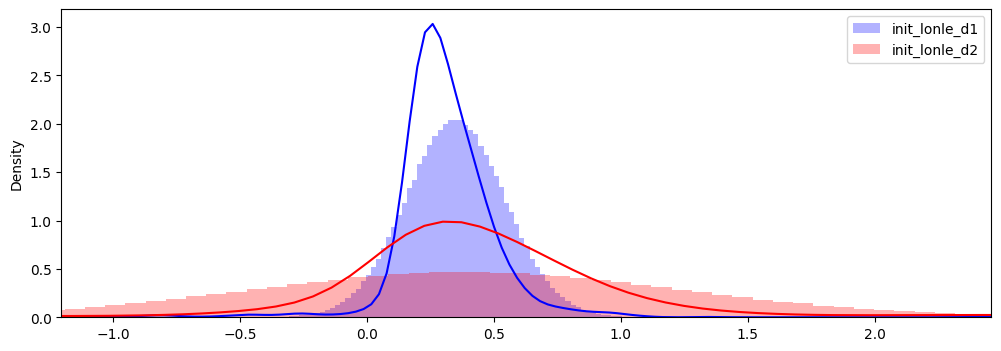

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# initialization process:

# plot density line of the indicator, using Sheather-Jones

indicator_values = indicator_d1_train.values.ravel()

# Plot KDE with Sheather-Jones bandwidth estimator
sns.kdeplot(indicator_values, bw_method='scott', c="blue")  # 'scott' is equivalent to Sheather-Jones in seaborn
plt.hist(ppc.posterior_predictive["init_d1"].values.ravel(), bins=100, density=True, alpha=0.3, color="blue", label="init_lonle_d1")

percentile_A1 = np.percentile(indicator_values, 97.5)
percentile_B1 = np.percentile(indicator_values, 2.5)

indicator_values = indicator_d2_train.values.ravel()

sns.kdeplot(indicator_values, bw_method='scott', c="red")  # 'scott' is equivalent to Sheather-Jones in seaborn
plt.hist(ppc.posterior_predictive["init_d2"].values.ravel(), bins=100, density=True, alpha=0.3, color="red", label="init_lonle_d2")

percentile_A2 = np.percentile(indicator_values, 97.5)
percentile_B2 = np.percentile(indicator_values, 2.5)


plt.xlim(np.min([percentile_B1, percentile_B2]), np.max([percentile_A1, percentile_A2]))
plt.legend()
plt.show()


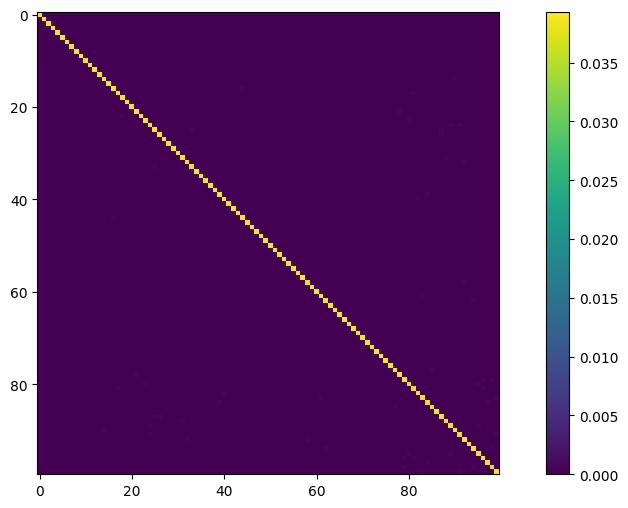

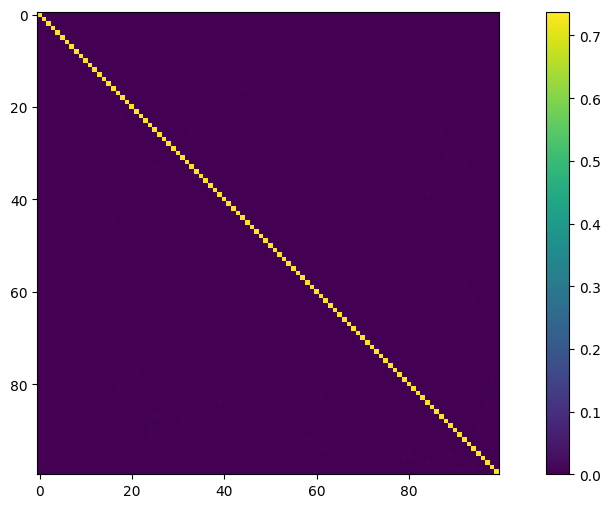

In [22]:
# init process - covariance

trace_iteration = trace.posterior.mean(dim=["chain", "draw"])

mu_init_d1 = trace_iteration["mu_init_d1"].values.ravel()
mu_init_d2 = trace_iteration["mu_init_d2"].values.ravel()

# nu_g_init_d1 = trace_iteration["nu_g_init_d1"].values.ravel()
nu_g_init_d1 = 0.5
kappa_g_init_d1 = trace_iteration["kappa_g_init_d1"].values.ravel()
sigma_g_init_d1 = trace_iteration["sigma_g_init_d1"].values.ravel()

# nu_g_init_d2 = trace_iteration["nu_g_init_d2"].values.ravel()
nu_g_init_d2 = 0.5
kappa_g_init_d2 = trace_iteration["kappa_g_init_d2"].values.ravel()
sigma_g_init_d2 = trace_iteration["sigma_g_init_d2"].values.ravel()


cov_init_d1 = GraphMaternKernel_numpy(eigenpairs=eigenpairs, vertex_dim=0, point_kernel=None, nu=nu_g_init_d1, kappa=kappa_g_init_d1, sigma_f=sigma_g_init_d1)
cov_init_d2 = GraphMaternKernel_numpy(eigenpairs=eigenpairs, vertex_dim=0, point_kernel=None, nu=nu_g_init_d2, kappa=kappa_g_init_d2, sigma_f=sigma_g_init_d2)

sigma_d1 = cov_init_d1(used_ids[:,None])
sigma_d2 = cov_init_d2(used_ids[:,None])

corr_d1 = sigma_d1 / np.sqrt(np.outer(np.diag(sigma_d1), np.diag(sigma_d1)))
corr_d2 = sigma_d2 / np.sqrt(np.outer(np.diag(sigma_d2), np.diag(sigma_d2)))

plt.figure(figsize=(12, 6))

plt.imshow(sigma_d1)
plt.colorbar()
plt.show()


plt.figure(figsize=(12, 6))

plt.imshow(sigma_d2)
plt.colorbar()
plt.show()

# plt.scatter(graph.bins_df.loc[used_ids, "lon"], graph.bins_df.loc[used_ids, "lat"], c=corr_d2[:,20])
# plt.colorbar()
# plt.show()

# plt.plot(np.sort(corr_d2[:,:])[:,-10:].T)
# plt.show()

In [23]:
all_obs_ppc = []

n_chains = ppc.posterior_predictive["obs_" + str(1)].values.shape[0]
n_train_nodes = ppc.posterior_predictive["obs_" + str(1)].values.shape[2] // 2
n_samples_post = ppc.posterior_predictive["obs_" + str(1)].values.shape[1]

n_timesteps = graph.actions_ts_adjusted.shape[1]
for t in range(1, n_timesteps):
    all_obs_ppc.append(ppc.posterior_predictive["obs_" + str(t)].values)

all_obs_ppc = np.array(all_obs_ppc)
all_obs_ppc_d1 = all_obs_ppc[:,:,:,:n_train_nodes]
all_obs_ppc_d2 = all_obs_ppc[:,:,:,n_train_nodes:]
all_obs_ppc = np.stack([all_obs_ppc_d1, all_obs_ppc_d2])

all_obs_ppc = all_obs_ppc.reshape(2, 21, n_chains * n_samples_post, n_train_nodes)

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_indicator_vs_prediction(indicator_df, ppc_df, action_ts_train, act, CIs=[[5, 95], [25, 75]], alphas=[0.1, 0.3], ax=None, xlim="auto", ylim="auto", xlabel=None, ylabel=None, alpha_points=0.1, title=None):
    """
    Plots the comparison between real and predicted indicators for a specific action.

    Parameters:
    - indicator_df: DataFrame containing the indicator data.
    - ppc_df: Posterior predictive samples.
    - action_ts_train: DataFrame containing the actions taken at each time step.
    - act: The action of interest (0, 1, 2, 3).
    - CIs: List of confidence intervals to plot (default is [[2.5, 97.5], [25, 75]]).
    - alphas: List of alpha values for shading the confidence intervals.
    - ax: Matplotlib axis object to plot on (if None, a new figure and axis will be created).
    
    Returns:
    - ax: The axis object with the plot.
    """

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))

    # REAL DATA:
    action_of_interest = (action_ts_train.values[:, :-1] == act)
    prev_indicator = indicator_df.values[:, :-1][action_of_interest]
    next_indicator = indicator_df.values[:, 1:][action_of_interest]

    CI_prev_A = np.percentile(prev_indicator, 97.5)
    CI_prev_B = np.percentile(prev_indicator, 2.5)
    CI_next_A = np.percentile(next_indicator, 97.5)
    CI_next_B = np.percentile(next_indicator, 2.5)

    # PREDICTED:
    order_plot = np.argsort(prev_indicator)

    for i, CI in enumerate(CIs):
        CI_pred_A = np.percentile(ppc_df, CI[1], axis=1).T[action_of_interest]
        CI_pred_B = np.percentile(ppc_df, CI[0], axis=1).T[action_of_interest]
        
        # Sorting the predicted intervals
        CI_pred_A_sorted = CI_pred_A[order_plot]
        CI_pred_B_sorted = CI_pred_B[order_plot]

        ax.fill_between(x=prev_indicator[order_plot].tolist(), y1=CI_pred_B_sorted.tolist(), 
                        y2=CI_pred_A_sorted.tolist(), alpha=alphas[i], color="blue", 
                        label=f"CI {CI[0]}-{CI[1]}")

    ax.scatter(prev_indicator, next_indicator, alpha=alpha_points, color="red", label="Real data")
    if xlim == "auto":
        xlim = [CI_prev_B, CI_prev_A]
    ax.set_xlim(xlim)
    if ylim == "auto":
        ylim = [CI_next_B, CI_next_A]
    ax.set_ylim(ylim)
    # ax.plot([CI_prev_B-2, CI_prev_A+2], [CI_next_B-2, CI_next_A+2], color="black", linestyle="--")
    # 45° line:
    ax.plot([-10, 10], [-10, 10], color="black", linestyle="--")
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if title is not None:
        ax.set_title(title)
    ax.legend()

    return ax


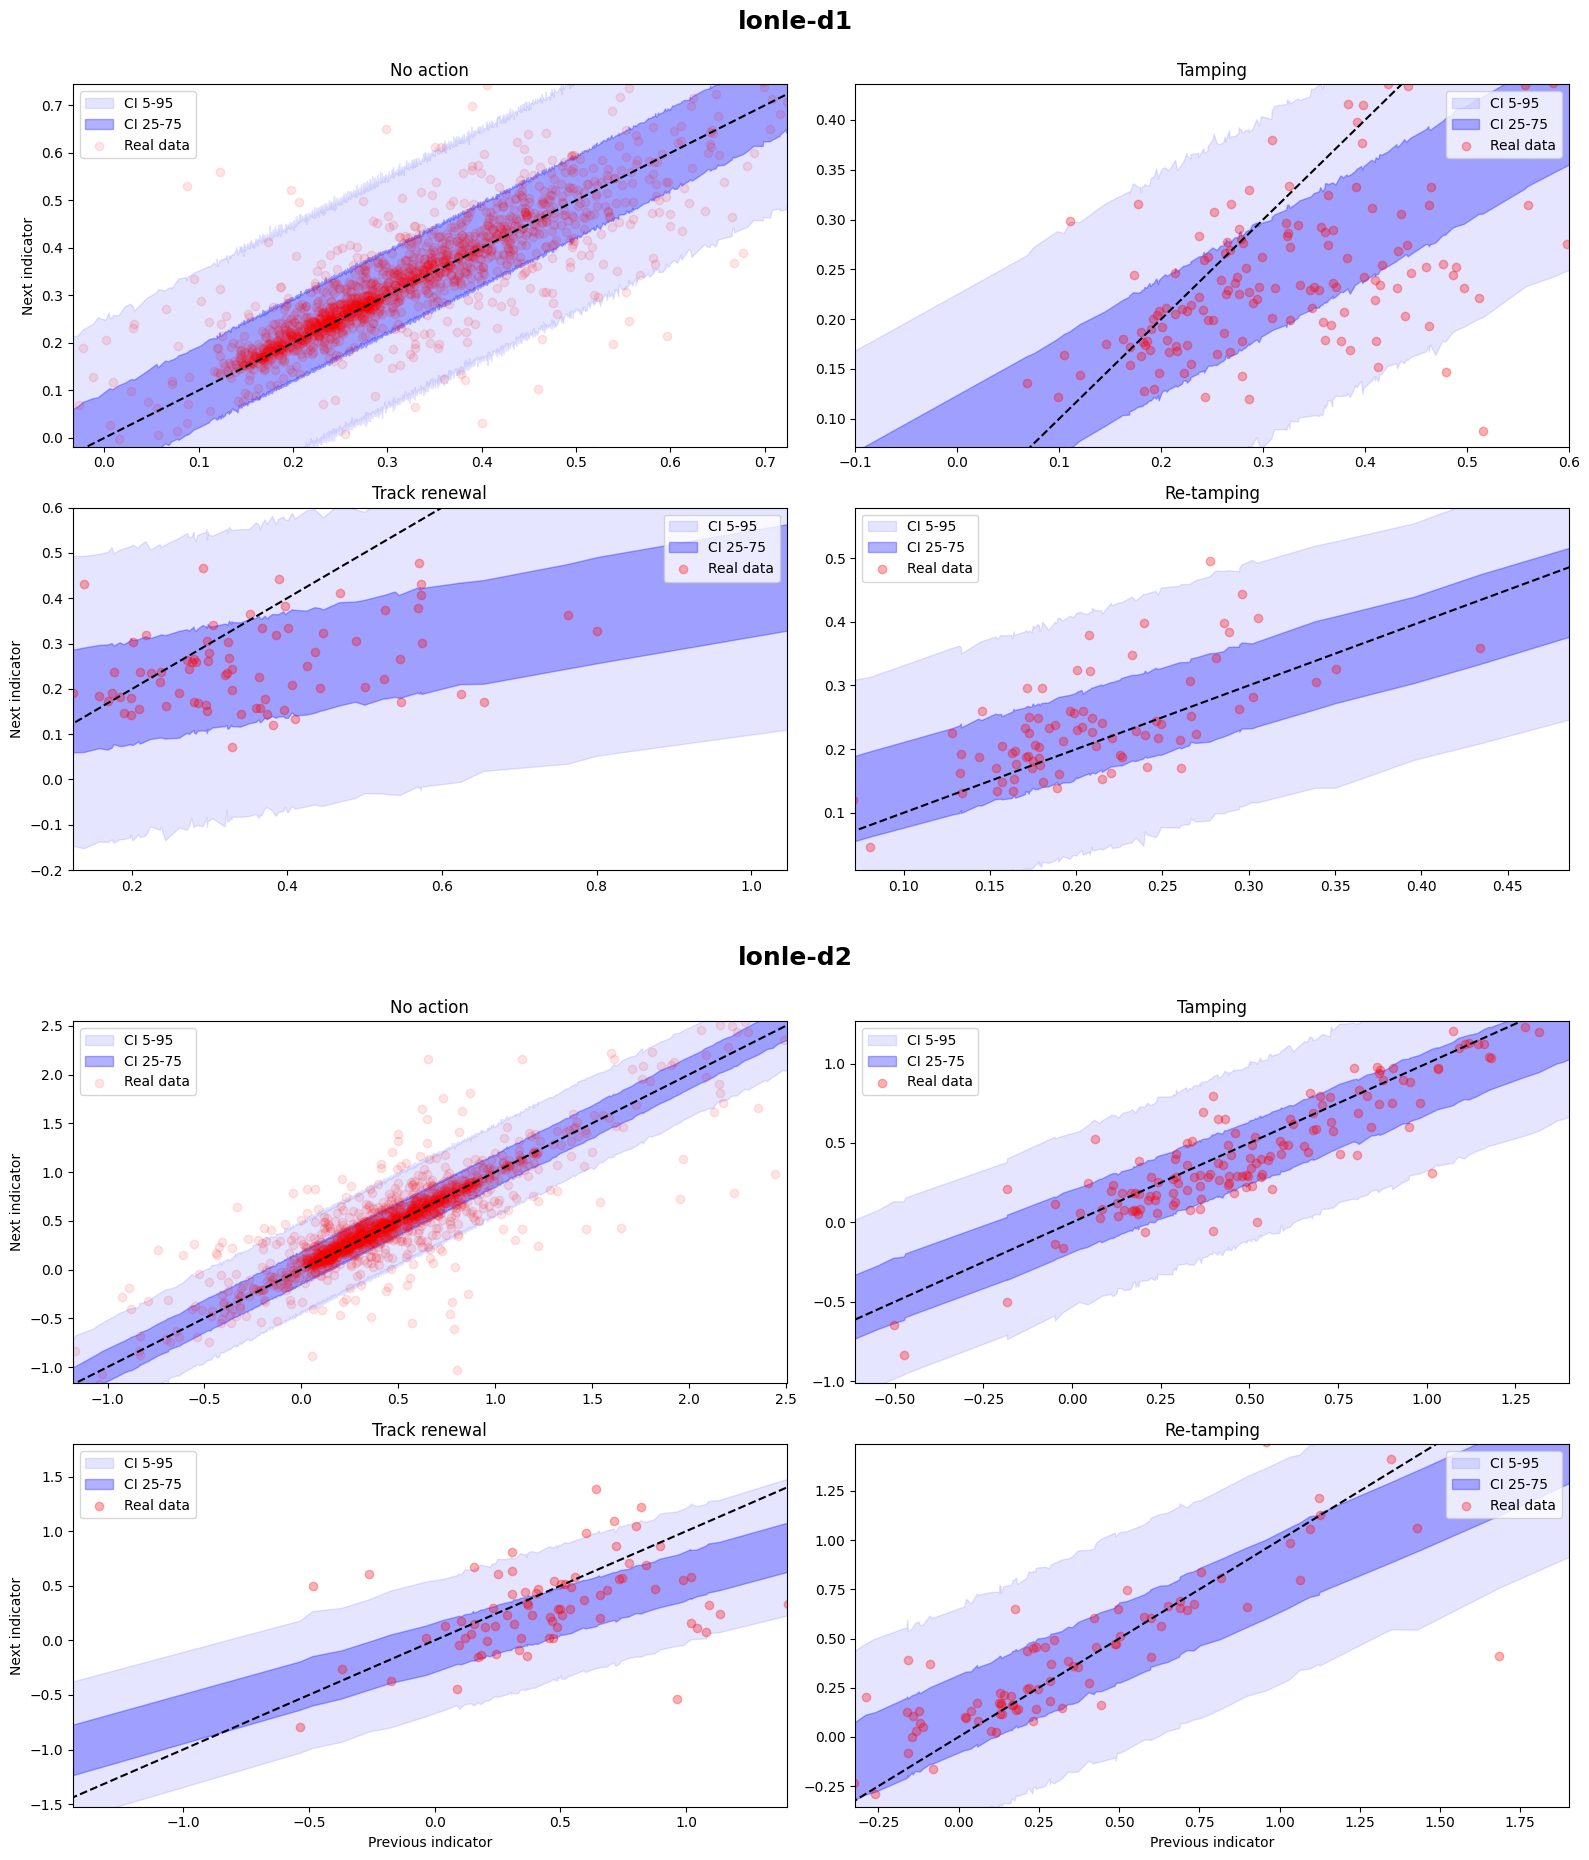

In [25]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 18))

fig.text(0.5, 0.97, "lonle-d1", ha='center', fontsize=18, fontweight='bold')
plot_indicator_vs_prediction(indicator_d1_train, all_obs_ppc[0], action_ts_train, 0, ax=axes[0, 0], xlabel=None, ylabel="Next indicator", title="No action")
plot_indicator_vs_prediction(indicator_d1_train, all_obs_ppc[0], action_ts_train, 2, ax=axes[0, 1], alpha_points=0.3, xlim=(-0.1,0.6), title="Tamping")
plot_indicator_vs_prediction(indicator_d1_train, all_obs_ppc[0], action_ts_train, 3, ax=axes[1, 0], xlabel=None, ylabel="Next indicator", alpha_points=0.3, ylim=(-0.2,0.6), title="Track renewal")
plot_indicator_vs_prediction(indicator_d1_train, all_obs_ppc[0], action_ts_train, 1, ax=axes[1, 1], alpha_points=0.3, title="Re-tamping")


fig.text(0.5, 0.45, "lonle-d2", ha='center', fontsize=18, fontweight="bold")
plot_indicator_vs_prediction(indicator_d2_train, all_obs_ppc[1], action_ts_train, 0, ax=axes[2, 0], xlabel=None, ylabel="Next indicator", title="No action")
plot_indicator_vs_prediction(indicator_d2_train, all_obs_ppc[1], action_ts_train, 2, ax=axes[2, 1], alpha_points=0.3, title="Tamping")
plot_indicator_vs_prediction(indicator_d2_train, all_obs_ppc[1], action_ts_train, 3, ax=axes[3, 0], xlabel="Previous indicator", ylabel="Next indicator", alpha_points=0.3, title="Track renewal")
plot_indicator_vs_prediction(indicator_d2_train, all_obs_ppc[1], action_ts_train, 1, ax=axes[3, 1], xlabel="Previous indicator", alpha_points=0.3, title="Re-tamping")

plt.tight_layout(rect=[0, 0, 1, 0.96])
for ax in axes[2, :]:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 - 0.05, pos.width, pos.height])

for ax in axes[3, :]:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 - 0.05, pos.width, pos.height])


plt.show()

In [26]:
# PLOT COVARIANCE MATRIX


example_input = np.stack([
    used_ids.tolist() *2, 
    np.random.choice(4, len(used_ids)*2, p=[0.7,0.1,0.1,0.1]).tolist(), 
    np.array([0] * used_ids.shape[0] + [1] * used_ids.shape[0])], axis=1)


# nu_g = trace.posterior[f"nu_g_init_d1"].mean().values
nu_g = 0.1
kappa_g = trace.posterior[f"kappa_g"].mean().values
sigma_g = trace.posterior[f"sigma_g"].mean().values
ls_act = trace.posterior[f"ls_act"].mean().values
ls_ind = trace.posterior[f"ls_ind"].mean().values

print("nu: ", nu_g)
print("kappa: ", kappa_g)
print("sigma: ", sigma_g)
print("ls act: ", ls_act)
print("ls ind: ", ls_ind)

fake_gp_cov = pm.gp.cov.Matern52(2, ls=[ls_act, ls_ind])
cov_fun = GraphMaternKernel(eigenpairs=eigenpairs, vertex_dim=2, point_kernel=fake_gp_cov, nu=nu_g, kappa=kappa_g, sigma_f=sigma_g)

cov_matrix = cov_fun(example_input).eval()
cov_matrix_diag = np.diag(cov_matrix)
lam_act_d1 = np.concatenate([[1],trace.posterior[f"lambda_act_d1"].values.mean(axis=(0,1))], axis=0)
lam_act_d2 = np.concatenate([[1],trace.posterior[f"lambda_act_d2"].values.mean(axis=(0,1))], axis=0)
lam_ind = np.concatenate([[1],trace.posterior[f"lambda_ind"].values.mean(axis=(0,1))], axis=0)
effect_action_t_d1 = (lam_act_d1 - 1)[example_input[:len(used_ids),1].astype(int)]
effect_action_t_d2 = (lam_act_d2 - 1)[example_input[len(used_ids):,1].astype(int)]
effect_action_t = np.concatenate([effect_action_t_d1, effect_action_t_d2], axis=0)
effect_ind_t = (lam_ind - 1)[example_input[:,2].astype(int)]

cov_matrix_diag_2 = cov_matrix_diag * effect_action_t + cov_matrix_diag * effect_ind_t

final_cov_matrix = cov_matrix + np.diag(cov_matrix_diag_2)

corr_matrix = final_cov_matrix / np.sqrt(np.outer(np.diag(final_cov_matrix), np.diag(final_cov_matrix)))

nu:  0.1
kappa:  0.044815915997812095
sigma:  0.01430734461205081
ls act:  0.39822398603671605
ls ind:  2.2937040973929417


/tmp/ipykernel_16043/595552911.py:40: RuntimeWarning: invalid value encountered in sqrt
  corr_matrix = final_cov_matrix / np.sqrt(np.outer(np.diag(final_cov_matrix), np.diag(final_cov_matrix)))


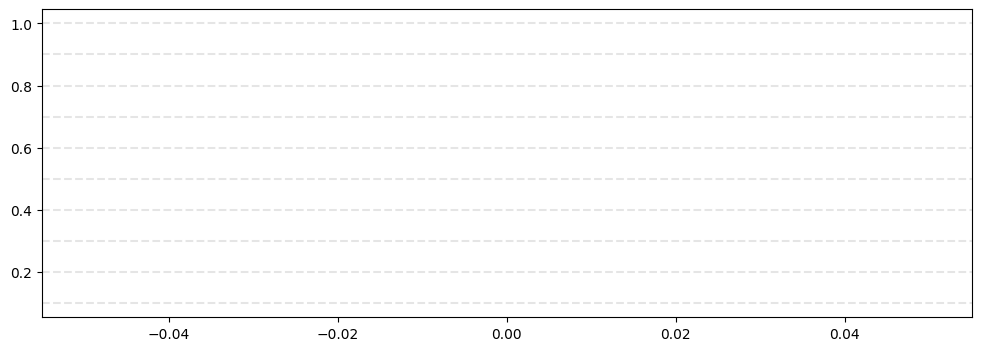

[nan nan nan nan nan]


In [27]:
n_plot = 15
plt.plot(np.arange(-n_plot,0,1), np.sort(corr_matrix[45])[-n_plot:])
for i in range(10):
    plt.axhline(0.1*(i+1), color='grey', linestyle="--", alpha=0.2)
plt.show()
print(np.sort(corr_matrix[45])[-5:])

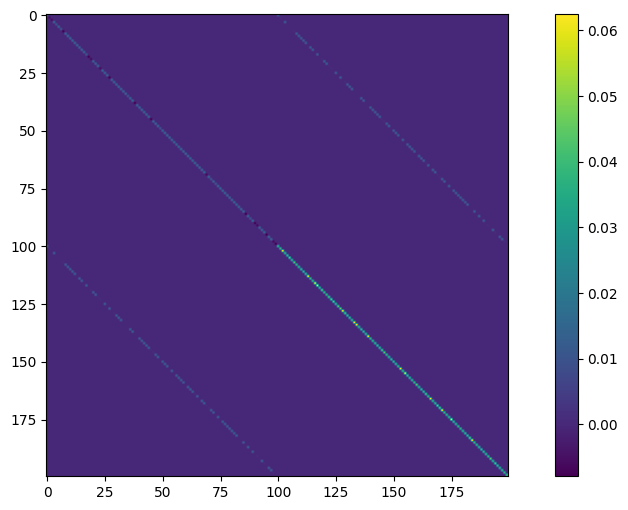

In [28]:
plt.figure(figsize=(12, 6))
plt.imshow(final_cov_matrix)
plt.colorbar()

plt.show()

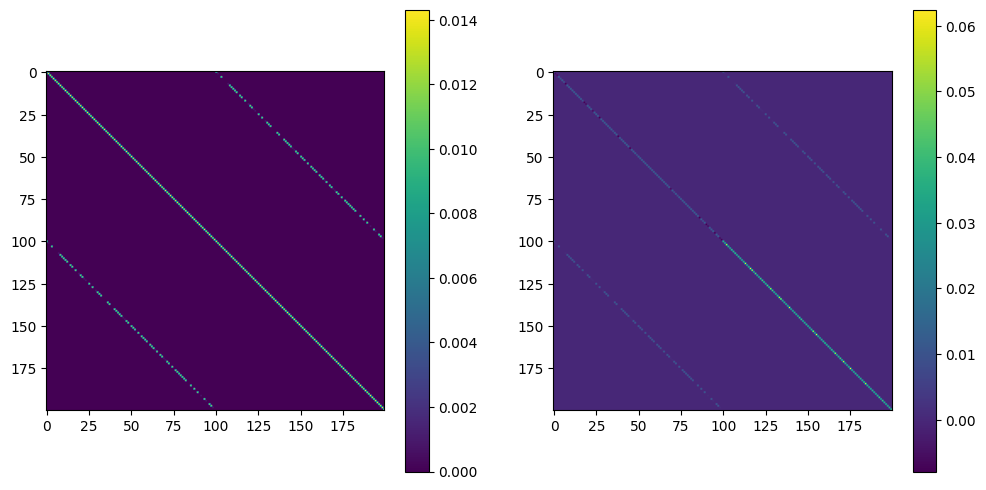

In [29]:
# plot next to each other imshow of cov_matrix and corr_d1_d_true

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cov_matrix)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(final_cov_matrix)
plt.colorbar()

plt.show()

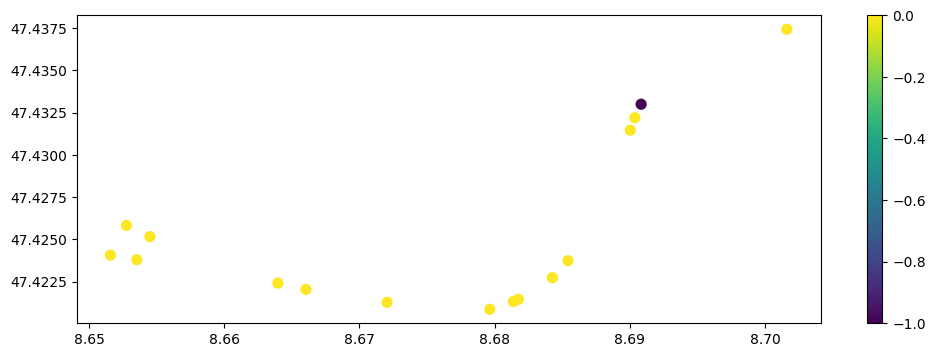

In [30]:
node_comp = 45
plt_corr = True
plt_ind = 1

if plt_corr:
    plt.show()
    if plt_ind == 1:
        plt.scatter(graph.bins_df.loc[used_ids,"lon"], graph.bins_df.loc[used_ids,"lat"], c=corr_matrix[node_comp,:len(used_ids)], s=50)
    else:
        plt.scatter(graph.bins_df.loc[used_ids,"lon"], graph.bins_df.loc[used_ids,"lat"], c=corr_matrix[node_comp,len(used_ids):], s=50)
else:
    plt.show()
    plt.scatter(graph.bins_df.loc[used_ids,"lon"], graph.bins_df.loc[used_ids,"lat"], c=final_cov_matrix[node_comp,:], s=50)
plt.colorbar()
plt.show()

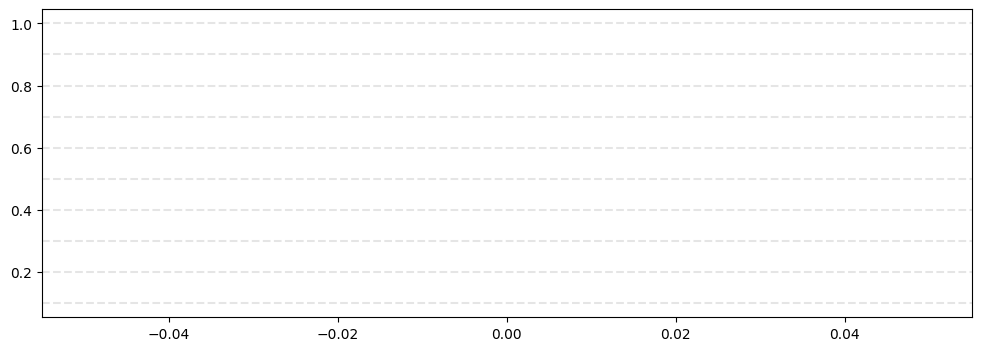

In [31]:
n_plot = 15
plt.plot(np.arange(-n_plot,0,1), np.sort(corr_matrix[node_comp])[-n_plot:])
for i in range(10):
    plt.axhline(0.1*(i+1), color='grey', linestyle="--", alpha=0.2)
plt.show()

In [34]:
# load data from /cluster/home/mullec/THESIS/MasterThesis_MaRL_Maintenance_GraphBased_railway_network/storage_pickles_other/EM_ONLY_E_conditionals.pickle
import pickle
sample_file = "1223_1153___REPORT___1500s_2500t_4c___REPORT_adjusted__lonle_d1lonle_d2___samples_post_mean"

with open(f"./storage_inference/{sample_file}.pkl", "rb") as file:
    samples_post = pickle.load(file)
    samples_post = samples_post[samples_post[:,0,0,0] != 0]
print(samples_post.shape)

(50, 100, 22, 2)


In [35]:
PROP_OF_TEST_NODES = 1 # use 100% of the nodes for testing, as we did to generate samples
RND_SEED = 42
np.random.seed(RND_SEED)

n_test_nodes = int(PROP_OF_TEST_NODES * len(used_ids))
test_ids = np.random.choice(used_ids, n_test_nodes, replace=False)
train_ids = np.setdiff1d(used_ids, test_ids)

indicator_d1_train = indicator_d1_used.loc[train_ids, :]
indicator_d1_test = indicator_d1_used.loc[test_ids, :]
indicator_d2_train = indicator_d2_used.loc[train_ids, :]
indicator_d2_test = indicator_d2_used.loc[test_ids, :]
action_ts_train = action_ts_used.loc[train_ids, :]
action_ts_test = action_ts_used.loc[test_ids, :]

indicator_d1_d_train = indicator_d1_d_used.loc[train_ids, :]
indicator_d1_d_test = indicator_d1_d_used.loc[test_ids, :]
indicator_d2_d_train = indicator_d2_d_used.loc[train_ids, :]
indicator_d2_d_test = indicator_d2_d_used.loc[test_ids, :]

print("Train nodes:\t", len(train_ids))
print("Test nodes:\t", len(test_ids))

Train nodes:	 0
Test nodes:	 100


80


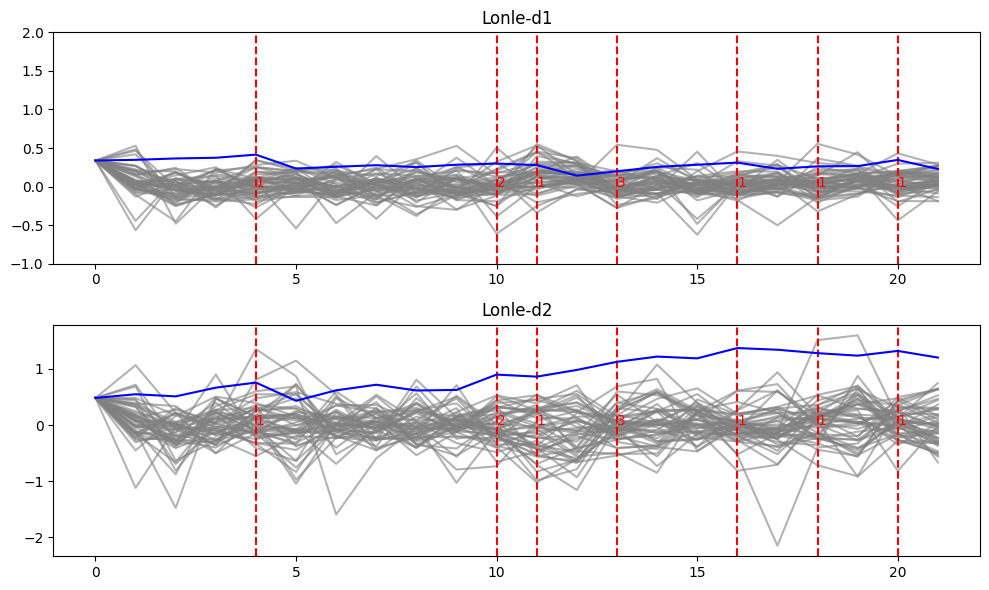

In [36]:
while True:

    node_id = np.random.choice(samples_post.shape[1])
    if np.sum(action_ts_test.values[node_id]) > 2:
        break

print(node_id)
n_timesteps_sample = samples_post.shape[2]
node_id=12

text_per_action = {
    1:"3",
    2:"1",
    3:"2",
}

indicator = 0
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Plot for indicator == 0
axs[0].plot(samples_post[1:,node_id,:,indicator].T, color="grey", alpha=np.min([30/samples_post.shape[0],1]))
axs[0].plot(samples_post[0,node_id,:,indicator].T, color="grey", alpha=np.min([30/samples_post.shape[0],1]), label="Sample")

for t in range(n_timesteps_sample):
    if action_ts_test.values[node_id,t] != 0:
        axs[0].axvline(t, color='r', linestyle="--")
        axs[0].text(t, 0, text_per_action[action_ts_test.values[node_id, t]], color='r')

# set lim x
axs[0].set_ylim(-1, 2)

axs[0].plot(indicator_d1_test.values[node_id,:], color="b", label="True")
axs[0].set_title("Lonle-d1")
# axs[0].legend()

# Plot for indicator == 1
indicator = 1
axs[1].plot(samples_post[1:,node_id,:,indicator].T, color="grey", alpha=np.min([30/samples_post.shape[0],1]))
axs[1].plot(samples_post[0,node_id,:,indicator].T, color="grey", alpha=np.min([30/samples_post.shape[0],1]), label="Sample")

for t in range(n_timesteps_sample):
    if action_ts_test.values[node_id,t] != 0:
        axs[1].axvline(t, color='r', linestyle="--")
        axs[1].text(t, 0, text_per_action[action_ts_test.values[node_id, t]], color='r')

axs[1].plot(indicator_d2_test.values[node_id,:], color="b", label="True")
axs[1].set_title("Lonle-d2")
# axs[1].set_ylim(-1, 3)

# axs[1].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
